In [1]:
import sys
sys.path.append('../r2d2_algo/')
import numpy as np
from gym import spaces
import torch
from torch import nn
from segment_tree import SumSegmentTree, MinSegmentTree
import random
import torch
from torch import nn
import torch.nn.functional as F
from model import RNNQNetwork, linear_schedule
from storage import ContinuousSequenceReplayBuffer, SequenceReplayBuffer
from envs import make_vec_envs
import torch.optim as optim
import random
import numpy as np
import gym
import gym_nav
import time
%run ../r2d2_algo/r2d2_class.py

    
    
    
def get_action_dim(action_space):
    """
    Get the dimension of the action space.
    """
    if isinstance(action_space, spaces.Box):
        return int(np.prod(action_space.shape))
    elif isinstance(action_space, spaces.Discrete):
        # Action is an int
        return 1
    elif isinstance(action_space, spaces.MultiDiscrete):
        # Number of discrete actions
        return int(len(action_space.nvec))
    elif isinstance(action_space, spaces.MultiBinary):
        # Number of binary actions
        assert isinstance(
            action_space.n, int
        ), "Multi-dimensional MultiBinary action space is not supported. You can flatten it instead."
        return int(action_space.n)
    else:
        raise NotImplementedError(f"{action_space} action space is not supported")

In [38]:
env_kwargs = {
        'num_objects': 0, 'rew_structure': 'goal',
        'task_structure': 2, 'wall_colors': 4,
        'num_rays': 12, 'fov': 1
}
env = gym.make('NavEnv-v0', **env_kwargs)
agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs,
                 verbose=1, buffer_size=1000, batch_size=256,
                 burn_in_length=4, n_envs=4, dummy_env=True,
                 learning_starts=1000, train_frequency=8)

In [39]:
agent.train(1)

Mean episode length 22.0, mean return 0.0
Mean episode length 22.0, mean return 0.0


In [17]:
agent.collect(2)

In [25]:
sample = agent.rb.sample(256)

In [29]:
agent.rb.pos

3

In [28]:
agent.rb.full

False

In [27]:
len(agent.rb)

3

In [19]:
agent.global_step

56024

In [286]:
sample = agent.rb.sample(256)

In [287]:
sample['observations'].shape

torch.Size([37, 16, 24])

In [144]:

action, q_values, next_rnn_hxs = agent.act(agent.obs, agent.rnn_hxs, masks=agent.masks)
env = agent.env
next_obs, reward, done, info = env.step(action)


In [46]:
agent.batch_size

256

In [89]:
sample = agent.rb.sample(256)
states = sample['observations']
next_states = sample['next_observations']
hidden_states = sample['hidden_states']
next_hidden_states = sample['next_hidden_states']
actions = sample['actions']
rewards = sample['rewards']
dones = sample['dones']
next_dones = sample['next_dones']
#training_masks are given by SequenceReplayBuffer
training_masks = sample['training_masks']

with torch.no_grad():
    target_q, _, _ = agent.target_network(next_states, next_hidden_states, next_dones)
    target_max, _ = target_q.max(dim=2)
    td_target = rewards + agent.gamma * target_max * (1 - dones)
old_q, _, _ = agent.q_network(states, hidden_states, dones)
old_val = old_q.gather(2, actions.long()).squeeze(2)

# loss = F.mse_loss(td_target[:, agent.burn_in_length:], old_val[:, agent.burn_in_length:])
weights = sample['weights']
elementwise_loss = F.smooth_l1_loss(td_target[:, agent.burn_in_length:],
                                    old_val[:, agent.burn_in_length:], reduction='none')
# loss = torch.mean(elementwise_loss * weights)
loss = torch.mean(elementwise_loss * weights * training_masks)

if agent.writer is not None and agent.global_update_step % 10 == 0:
    agent.writer.add_scalar('losses/td_loss', loss, agent.global_step)
    agent.writer.add_scalar('losses/q_values', old_val.mean().item(), agent.global_step)
    sps = int(agent.global_step / (time.time() - agent.start_time))
    # print('SPS:', int(sps))
    agent.writer.add_scalar('charts/SPS', sps, agent.global_step)

agent.optimizer.zero_grad()
loss.backward()
agent.optimizer.step()

# PER: update priorities
td_priorities = elementwise_loss.mean(dim=1).detach().cpu().numpy() + 1e-6
agent.rb.update_priorities(sample['idxs'], td_priorities)

In [82]:
sample['weights']

tensor([[0.1175]])

In [83]:
old_val.shape

torch.Size([1, 12])

In [57]:
agent.rb.training_masks[152]

array([1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [56]:
agent.rb.dones[152]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [54]:
sample['idxs'][5]

152

In [51]:
training_masks

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0

In [50]:
dones

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0

In [45]:
training_masks.sum()

tensor(36.)

In [42]:
states.shape

torch.Size([6, 12, 24])

In [25]:
hidden_states.shape

torch.Size([1, 4, 64])

In [26]:
next_hidden_states.shape

torch.Size([1, 4, 64])

In [21]:
elementwise_loss

tensor([[1.4553e-07, 1.4515e-07, 1.3384e-02, 5.2076e-02, 1.4448e-07, 1.3384e-02,
         1.3384e-02, 1.4449e-07],
        [3.6777e-03, 4.0718e-09, 4.7054e-02, 1.3871e-07, 3.8636e-03, 4.7342e-02,
         3.9526e-03, 4.7866e-02],
        [1.1588e-07, 1.1506e-07, 1.1452e-07, 1.1419e-07, 1.1399e-07, 1.1389e-07,
         1.1383e-07, 1.1381e-07],
        [4.9114e-02, 2.0491e-07, 2.0749e-07, 2.0899e-07, 2.0985e-07, 2.1033e-07,
         2.1063e-07, 2.1083e-07]], grad_fn=<SmoothL1LossBackward0>)

In [13]:
elementwise_loss.max(dim=1)[0].detach()

tensor([7.2243e-04, 9.7215e-04, 1.3732e-05, 2.8302e-06])

In [357]:
agent.rb.cur_dones

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [358]:
agent.rb.cur_observations[:, :, 5:10]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        ,

# Setup specific environment and step collection tests

In [2]:
env_kwargs = {
    'num_objects': 0, 'rew_structure': 'goal',
    'task_structure': 2, 'wall_colors': 4,
    'num_rays': 12, 'fov': 1, 'fixed_reset': [np.array([50, 50]), np.pi/2]
}
env = gym.make('NavEnv-v0', **env_kwargs)

agent = R2D2Agent(env_id='NavEnv-v0', env_kwargs=env_kwargs,
                 verbose=1, buffer_size=1000, batch_size=256,
                 burn_in_length=4, n_envs=2, dummy_env=True,
                 learning_starts=1000, train_frequency=8)

In [3]:
fixed_actions = [[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, #reaches goal here at 34 steps
                  1, 1, 1, 0, 0, 0],
           [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0]]

env = agent.env
rb = agent.rb
num_steps = 40
for t in range(num_steps):
    outputs = agent.act(agent.obs, agent.rnn_hxs, masks=agent.masks)
    # action = outputs['action']
    action = np.array([[fixed_actions[0][t]], [fixed_actions[1][t]]], dtype='int64')
    next_rnn_hxs = outputs['next_rnn_hxs']
    next_obs, reward, done, info = env.step(action)

    agent.cur_episode_r += reward
    agent.cur_episode_t += 1

    # Masks are used to reset hidden state when vectorized environmnts give dones
    agent.masks = torch.FloatTensor(
        [[0.0] if done_ else [1.0] for done_ in done])

    for i, done_ in enumerate(done):
        if done_:
            agent.lengths.append(agent.cur_episode_t[i])
            agent.returns.append(agent.cur_episode_r[i])

            agent.cur_episode_r[i] = 0
            agent.cur_episode_t[i] = 0


    agent.rb.add(agent.obs, next_obs, action, reward, done, agent.rnn_hxs.detach())

    agent.obs = next_obs
    agent.rnn_hxs = next_rnn_hxs


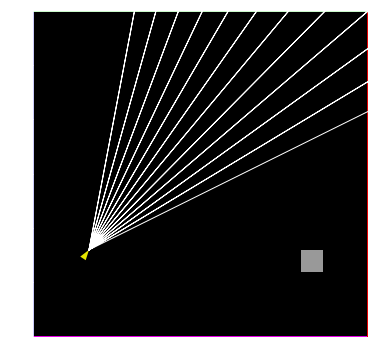

In [4]:
env.envs[0].render()

In [5]:
random.seed(1)
np.random.seed(1)

sample = rb.sample(4)

In [6]:
sample['dones']

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
sample['rewards']

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [25]:
final_q, _, _ = agent.target_network(next_states[:, -1:], all_next_hidden_states[:, -1].unsqueeze(0), next_dones[:, -1:])


In [26]:
q

tensor([[[-0.1029, -0.0561, -0.0476, -0.0222]],

        [[-0.1041, -0.0559, -0.0486, -0.0281]],

        [[-0.1022, -0.0569, -0.0512, -0.0269]],

        [[-0.0996, -0.0576, -0.0494, -0.0339]]], grad_fn=<ViewBackward0>)

In [28]:
target_q[:, -1, :]

tensor([[-0.1029, -0.0561, -0.0476, -0.0222],
        [-0.1041, -0.0559, -0.0486, -0.0279],
        [-0.1022, -0.0569, -0.0512, -0.0269],
        [-0.0996, -0.0576, -0.0494, -0.0339]])

In [ ]:
rb.hidden_states[sample['seq_idxs']+1, sample['env_idxs']]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4,12) (4,) 

In [ ]:
rb

In [43]:
target_max[:, -1]

tensor([-0.0222, -0.0279, -0.0269, -0.0339])

In [41]:
q_max.squeeze()

tensor([-0.0222, -0.0281, -0.0269, -0.0339])

In [39]:
returns[:, -1].shape

torch.Size([4])

In [46]:
returns

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0222],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0281],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0269],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0339]])

In [ ]:
retu

In [55]:
gamma = 0.99
states = sample['observations']
next_states = sample['next_observations']
hidden_states = sample['hidden_states']
next_hidden_states = sample['next_hidden_states']
all_next_hidden_states = sample['all_next_hidden_states']
actions = sample['actions']
rewards = sample['rewards']
dones = sample['dones']
next_dones = sample['next_dones']

# Compute returns
with torch.no_grad():
    returns = torch.zeros((rewards.shape[0], rewards.shape[1]+1))
    final_q, _, _ = agent.target_network(next_states[:, -1:], all_next_hidden_states[:, -1].unsqueeze(0), next_dones[:, -1:])
    q_max, _ = final_q.max(dim=2)
    returns[:, -1] = q_max.squeeze()
    
    for step in reversed(range(rewards.shape[1])):
        returns[:, step] = returns[:, step+1] * gamma * (1 - dones[:, step]) + rewards[:, step]
    td_target = returns[:, :-1]
# with torch.no_grad():
#     target_q, _, _ = agent.target_network(next_states, next_hidden_states, next_dones)
#     target_max, _ = target_q.max(dim=2)
#     td_target = rewards + agent.gamma * target_max * (1 - dones)
    
    
old_q, _, _ = agent.q_network(states, hidden_states, dones)
old_val = old_q.gather(2, actions.long()).squeeze()

weights = sample['weights']
elementwise_loss = F.smooth_l1_loss(td_target[:, agent.burn_in_length:],
                                    old_val[:, agent.burn_in_length:], reduction='none')
loss = torch.mean(elementwise_loss * weights)

# agent.optimizer.zero_grad()
# loss.backward()
# agent.optimizer.step()

In [56]:
td_target.shape

torch.Size([4, 12])

In [52]:
td_target

tensor([[-0.0289, -0.0250, -0.0216, -0.0195, -0.0179, -0.0163, -0.0150, -0.0147,
         -0.0178, -0.0195, -0.0208, -0.0220],
        [-0.0305, -0.0314, -0.0318, -0.0325, -0.0332, -0.0340, -0.0349, -0.0316,
          1.0000, -0.0300, -0.0284, -0.0276],
        [-0.0195, -0.0208, -0.0220, -0.0233, -0.0244, -0.0254, -0.0265, -0.0275,
         -0.0245, -0.0246, -0.0255, -0.0266],
        [-0.0275, -0.0245, -0.0246, -0.0255, -0.0266, -0.0277, -0.0287, -0.0296,
         -0.0305, -0.0314, -0.0318, -0.0336]])

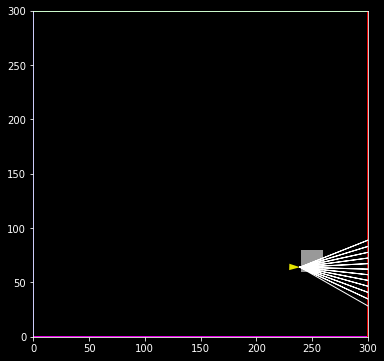

In [66]:
# env.step(1)
actions = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
for action in actions:
    env.step(action)
env.render()

In [ ]:
actions = [[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
           [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]